# Machine Learning Udacity Capstone Project
**"Sentiment analysis in airline tweets"**

Author: Luis Bronchal<br>Date: September 11, 2017

## Machine Learning Models for data codified as embeddings

## Summary

We have used the cleaned data obtained during the Exploratory Data Analysis. We have build tools to tokenize the tweets' text and to obtain custom embeddings from them. We have codified the tweet's text as average vectors of its tokens' embeddings. Several machine learning models have been tried on this transformed data and its performance has been compared.



## Models

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

We use the cleaned text we obtained in the EDA:

In [2]:
data = pd.read_csv("../output/data_clean.csv")

In [3]:
train, test = train_test_split(data, test_size=0.2, random_state=1)
X_train = train['text'].values
X_test = test['text'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [4]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [5]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [6]:
from gensim.models import Word2Vec

Using TensorFlow backend.


Classes and resources to convert text into vectors with the average value of its embeddings tokens: 

In [7]:
en_stopwords = set(stopwords.words("english"))  
stemmer = SnowballStemmer('english')
tknzr = TweetTokenizer()

In [8]:
from sklearn.base import TransformerMixin 

class MyTokenizer(TransformerMixin):  
    
    def __init__(self, stopwords=set()):
        self.toknizer = TweetTokenizer()
        self.stopwords = stopwords
        
    # X must be a DataFrame or a list, if it is a string it going to trait each character as a token    
    def transform(self, X, **transform_params):
        tmp_tokens = [self.toknizer.tokenize(text.lower()) for text in X]
        return [[i for i in token_list if i not in self.stopwords] for token_list in tmp_tokens]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}    
       

In [9]:
class MeanEmbeddingVectorizer(object):
    
    def __init__(self, min_count=5, size=300):
        self.size = size   
        self.min_count = min_count
    
    def fit(self, X, y):
        model = Word2Vec(X, min_count=self.min_count, size=self.size, workers=-1)
        w2v = dict(zip(model.wv.index2word, model.wv.syn0))
        self.word2vec = w2v
        self.dim = len(next(iter(w2v.values())))
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def get_params(self, deep=True):
        return {}     

Function to report results:

In [10]:
def report_results(model, X, y, neural_network=False):
    
    if (neural_network == False):
        pred_proba = model.predict_proba(X)[:, 1]
        pred = model.predict(X)        
    else:
        pred_proba = model.predict(X)
        pred = (pred_proba > 0.5).astype(int)


    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

Function to build the roc curve of a model

In [11]:
from sklearn.metrics import roc_curve, auc
    
def get_roc_curve(model, X, y, neural_network=False):
    if (neural_network == False):
        pred_proba = model.predict_proba(X)[:, 1]
    else:
        pred_proba = model.predict(X)

    fpr, tpr, threshold = roc_curve(y, pred_proba)

    return fpr, tpr, threshold

## Machine Learning Models

In [12]:
all_models = {}

### Logistic Regression

In [13]:
np.random.seed(1)

pipeline_lr = make_pipeline(MyTokenizer(stopwords=en_stopwords), 
                            MeanEmbeddingVectorizer(min_count=5, size=300), 
                            LogisticRegression(class_weight="balanced"))
parameters_lr = {'logisticregression__C': [80000, 90000, 100000]}
grid_lr = GridSearchCV(pipeline_lr,
                    param_grid = parameters_lr, 
                    cv = kfolds,
                    scoring = "roc_auc",
                    verbose = 1,   
                    n_jobs = -1)                       

grid_lr.fit(X_train, y_train)
grid_lr.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.5s finished


0.85244879909677718

In [14]:
grid_lr.best_params_

{'logisticregression__C': 100000}

In [15]:
tmp_model = 'lr'
all_models[tmp_model] = {}
all_models[tmp_model]['model'] = grid_lr
all_models[tmp_model]['roc_curve'] = get_roc_curve(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['train_preds'] = all_models[tmp_model]['model'].predict_proba(X_train)[:, 1]
all_models[tmp_model]['result'] = report_results(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['result']

{'acc': 0.77993409007689496,
 'auc': 0.85244879909677718,
 'f1': 0.82988961222756863,
 'precision': 0.85481049562682221,
 'recall': 0.80638063806380633}

### SVM

In [16]:
np.random.seed(1)

pipeline_svm = make_pipeline(MyTokenizer(stopwords=en_stopwords), 
                            MeanEmbeddingVectorizer(min_count=5, size=300), 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [3000, 3500, 4000]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 14.3min finished


0.84218391718689944

In [17]:
grid_svm.best_params_

{'svc__C': 4000}

In [18]:
grid_svm.cv_results_["mean_test_score"]

array([ 0.83828531,  0.84061527,  0.84262438])

In [19]:
grid_svm.cv_results_["mean_test_score"]

array([ 0.83828531,  0.84061527,  0.84262438])

In [20]:
tmp_model = 'svm'
all_models[tmp_model] = {}
all_models[tmp_model]['model'] = grid_svm
all_models[tmp_model]['roc_curve'] = get_roc_curve(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['train_preds'] = all_models[tmp_model]['model'].predict_proba(X_train)[:, 1]
all_models[tmp_model]['result'] = report_results(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['result']

{'acc': 0.78359575247162216,
 'auc': 0.84216885543976072,
 'f1': 0.8384804591418421,
 'precision': 0.83324280282455188,
 'recall': 0.84378437843784382}

What happens with this classifier is that it is predicting all cases as falses. The performance then is very bad. Simply doing the inverse, predicting all cases as true, would produce better results

### Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
np.random.seed(1)

pipeline_nb = make_pipeline(MyTokenizer(stopwords=en_stopwords), 
                            MeanEmbeddingVectorizer(min_count=5, size=300), 
                            MinMaxScaler(),
                            MultinomialNB())

grid_nb = GridSearchCV(pipeline_nb,
                    param_grid = {'multinomialnb__alpha': [.1, 1, 10]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_nb.fit(X_train, y_train)
grid_nb.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.0s finished


0.75290992954717162

In [22]:
grid_nb.best_params_

{'multinomialnb__alpha': 0.1}

In [23]:
tmp_model = 'nb'
all_models[tmp_model] = {}
all_models[tmp_model]['model'] = grid_nb
all_models[tmp_model]['roc_curve'] = get_roc_curve(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['train_preds'] = all_models[tmp_model]['model'].predict_proba(X_train)[:, 1]
all_models[tmp_model]['result'] = report_results(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['result']

{'acc': 0.67594287806664222,
 'auc': 0.75290992954717162,
 'f1': 0.80363878411360101,
 'precision': 0.67348456675343993,
 'recall': 0.99614961496149612}

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(1)

pipeline_rf = make_pipeline(MyTokenizer(stopwords=en_stopwords), 
                            MeanEmbeddingVectorizer(min_count=5, size=300), 
                            RandomForestClassifier(class_weight="balanced"))

grid_rf = GridSearchCV(pipeline_rf,
                    param_grid = {'randomforestclassifier__n_estimators': [200, 400], 
                                  'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_rf.fit(X_train, y_train)
grid_rf.score(X_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.2min finished


0.8371397380701926

In [25]:
grid_rf.best_params_

{'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__n_estimators': 400}

In [26]:
tmp_model = 'rf'
all_models[tmp_model] = {}
all_models[tmp_model]['model'] = grid_rf
all_models[tmp_model]['roc_curve'] = get_roc_curve(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['train_preds'] = all_models[tmp_model]['model'].predict_proba(X_train)[:, 1]
all_models[tmp_model]['result'] = report_results(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['result']

{'acc': 0.77151226656902239,
 'auc': 0.8371397380701926,
 'f1': 0.84765625,
 'precision': 0.76207199297629502,
 'recall': 0.95489548954895487}

### xgboost

In [27]:
from xgboost import XGBClassifier
from sklearn.base import TransformerMixin 

# Because bug in xgboost: https://github.com/dmlc/xgboost/issues/1238
class CSCTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.tocsc()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


np.random.seed(1)

pipeline_xgb = make_pipeline(MyTokenizer(stopwords=en_stopwords), 
                            MeanEmbeddingVectorizer(min_count=5, size=300), 
                            #CSCTransformer(), 
                            XGBClassifier())


parameters = {'xgbclassifier__learning_rate': [0.02, 0.05, 0.1], #`eta` value
              'xgbclassifier__min_child_weight': [1, 2],
              'xgbclassifier__max_depth': [6, 10],       
              'xgbclassifier__subsample': [0.5, 0.8, 1],
              'xgbclassifier__colsample_bytree': [0.7, 0.9],
              'xgbclassifier__n_estimators': [100, 500, 1000], #number of trees
}
grid_xgb = GridSearchCV(pipeline_xgb,
                    param_grid = parameters, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_xgb.fit(X_train, y_train)
grid_xgb.score(X_test, y_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/imac1/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 84.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 190.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 371.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 539.4min finished


0.88082513070584167

In [28]:
grid_xgb.best_params_

{'xgbclassifier__colsample_bytree': 0.9,
 'xgbclassifier__learning_rate': 0.05,
 'xgbclassifier__max_depth': 10,
 'xgbclassifier__min_child_weight': 2,
 'xgbclassifier__n_estimators': 1000,
 'xgbclassifier__subsample': 0.5}

In [29]:
tmp_model = 'xgb'
all_models[tmp_model] = {}
all_models[tmp_model]['model'] = grid_xgb
all_models[tmp_model]['roc_curve'] = get_roc_curve(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['train_preds'] = all_models[tmp_model]['model'].predict_proba(X_train)[:, 1]
all_models[tmp_model]['result'] = report_results(all_models[tmp_model]['model'], X_test, y_test)
all_models[tmp_model]['result']

{'acc': 0.81325521786891253,
 'auc': 0.88082513070584167,
 'f1': 0.86621196222455399,
 'precision': 0.82798395185556672,
 'recall': 0.90814081408140812}

### Deep Learning

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

In [31]:
def build_nn_model(embeddings_len=300):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=embeddings_len, kernel_initializer='random_uniform', activation='linear'))
    model.add(Dense(5, kernel_initializer='random_uniform', activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  
    return model  

In [32]:
np.random.seed(1)

folds = 5
epochs = 100
cvhistories = []
cvscores = []
i = 0

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0)

pipeline_nn = make_pipeline(MyTokenizer(stopwords=en_stopwords), 
                            MeanEmbeddingVectorizer())
    
for train_cv, test_cv in kfolds.split(X_train, y_train.values):

    tmp_vec = pipeline_nn.fit(X_train[train_cv])
    train_cv_dense = tmp_vec.transform(X_train[train_cv]) 
    test_cv_dense = tmp_vec.transform(X_train[test_cv])
     
    model_nn_cv = build_nn_model()

    cvhistory = model_nn_cv.fit(train_cv_dense, 
                                y_train.values[train_cv], 
                                validation_data = (test_cv_dense, y_train.values[test_cv]),  
                                callbacks = [early_stopping], 
                                class_weight = class_weight,
                                epochs = epochs, 
                                batch_size = 100,
                                verbose = 0)
    
    preds_cv = model_nn_cv.predict_proba(test_cv_dense, verbose=0).flatten()
    scores_cv = roc_auc_score(y_train.values[test_cv], preds_cv)
    cvscores.append(scores_cv)
    
    train_preds_cv = model_nn_cv.predict_proba(train_cv_dense, verbose=0).flatten()
    train_scores_cv = roc_auc_score(y_train.values[train_cv], train_preds_cv)
    
    #print("Validation auc: {:0.4f}".format(scores_cv))
    
    #print("Fold {:d} ==> Training auc: {:0.4f} / Validation auc: {:0.4f}". \
    #      format(i, train_scores_cv, scores_cv))  
    
    print("Fold {:d} ==> Training accuracy: {:0.4f} / Validation accuracy: {:0.4f}". \
          format(i, 100*cvhistory.history['acc'][-1], 100*cvhistory.history['val_acc'][-1]))     

    
    cvhistories.append(cvhistory)
    i+=1

Fold 0 ==> Training accuracy: 78.2828 / Validation accuracy: 76.5675
Fold 1 ==> Training accuracy: 77.9876 / Validation accuracy: 77.3352
Fold 2 ==> Training accuracy: 77.9991 / Validation accuracy: 77.7473
Fold 3 ==> Training accuracy: 77.9304 / Validation accuracy: 77.7015
Fold 4 ==> Training accuracy: 76.8799 / Validation accuracy: 74.6221


In [33]:
print("validation auc: {:0.4f} (+/- {:0.4f}%)".format(np.mean(cvscores), np.std(cvscores)))

validation auc: 0.8236 (+/- 0.0174%)


In [34]:
np.random.seed(1)

vec = pipeline_nn.fit(X_train)
X_train_dense = vec.transform(X_train)
X_test_dense = vec.transform(X_test)

model_nn = build_nn_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0)

np.random.seed(1)

history = model_nn.fit(X_train_dense, y_train, validation_split=0.2, 
                       class_weight = class_weight,
                       epochs = epochs, 
                       batch_size = 100, 
                       callbacks = [early_stopping], 
                       verbose = 1)

Train on 8736 samples, validate on 2184 samples
Epoch 1/100
8736/8736 [==============================] - 0s - loss: 0.6630 - acc: 0.6391 - val_loss: 0.6606 - val_acc: 0.6264
Epoch 2/100
8736/8736 [==============================] - 0s - loss: 0.6521 - acc: 0.6411 - val_loss: 0.6599 - val_acc: 0.6264
Epoch 3/100
8736/8736 [==============================] - 0s - loss: 0.6513 - acc: 0.6411 - val_loss: 0.6594 - val_acc: 0.6264
Epoch 4/100
8736/8736 [==============================] - 0s - loss: 0.6504 - acc: 0.6411 - val_loss: 0.6583 - val_acc: 0.6264
Epoch 5/100
8736/8736 [==============================] - 0s - loss: 0.6493 - acc: 0.6411 - val_loss: 0.6569 - val_acc: 0.62640.645
Epoch 6/100
8736/8736 [==============================] - 0s - loss: 0.6476 - acc: 0.6411 - val_loss: 0.6576 - val_acc: 0.6264
Epoch 7/100
8736/8736 [==============================] - 0s - loss: 0.6460 - acc: 0.6411 - val_loss: 0.6537 - val_acc: 0.6264
Epoch 8/100
8736/8736 [==============================] - 0s - los

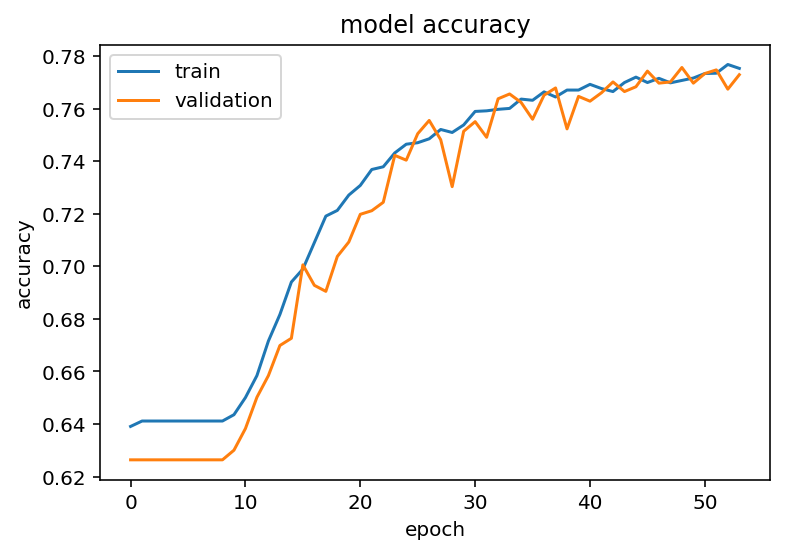

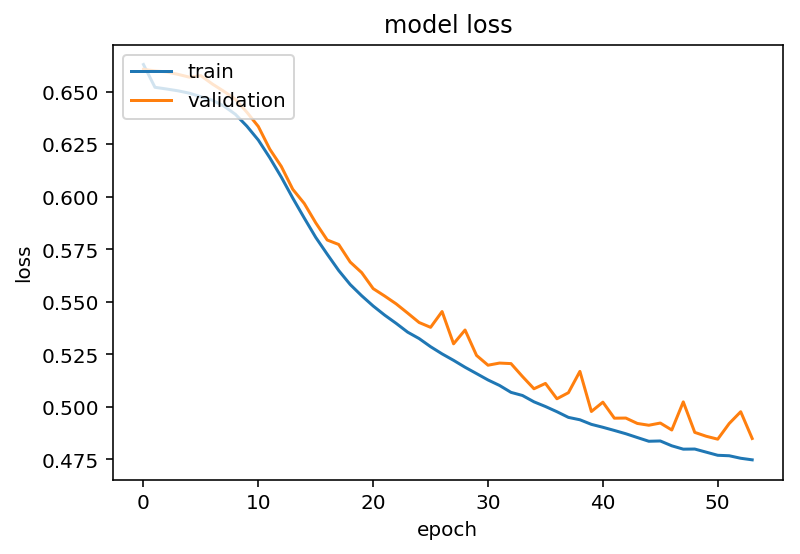

In [35]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
tmp_model = 'nn'
all_models[tmp_model] = {}
all_models[tmp_model]['model'] = model_nn
all_models[tmp_model]['roc_curve'] = get_roc_curve(all_models[tmp_model]['model'], 
                                                   X_test_dense, y_test, neural_network=True)
all_models[tmp_model]['train_preds'] = all_models['nn']['model'].predict(X_train_dense).flatten()
all_models[tmp_model]['result'] = report_results(all_models[tmp_model]['model'], 
                                                 X_test_dense, y_test, neural_network=True)
all_models[tmp_model]['result']

{'acc': 0.77846942511900408,
 'auc': 0.81208120812081197,
 'f1': 0.84491156113816979,
 'precision': 0.79116658665386463,
 'recall': 0.90649064906490651}

## Models comparison

In [37]:
all_models_name = all_models.keys()

tmp_list = []
for mo in all_models_name:
    tmp_list.append(all_models[mo]['result'])
models_results = pd.DataFrame(dict(zip(all_models_name, tmp_list))).transpose()    

In [38]:
models_results = models_results.sort_values(['auc'], ascending=False)
models_results

,acc,auc,f1,precision,recall
xgb,0.813255,0.880825,0.866212,0.827984,0.908141
lr,0.779934,0.852449,0.829890,0.854810,0.806381
svm,0.783596,0.842169,0.838480,0.833243,0.843784
rf,0.771512,0.837140,0.847656,0.762072,0.954895
nn,0.778469,0.812081,0.844912,0.791167,0.906491
nb,0.675943,0.752910,0.803639,0.673485,0.996150


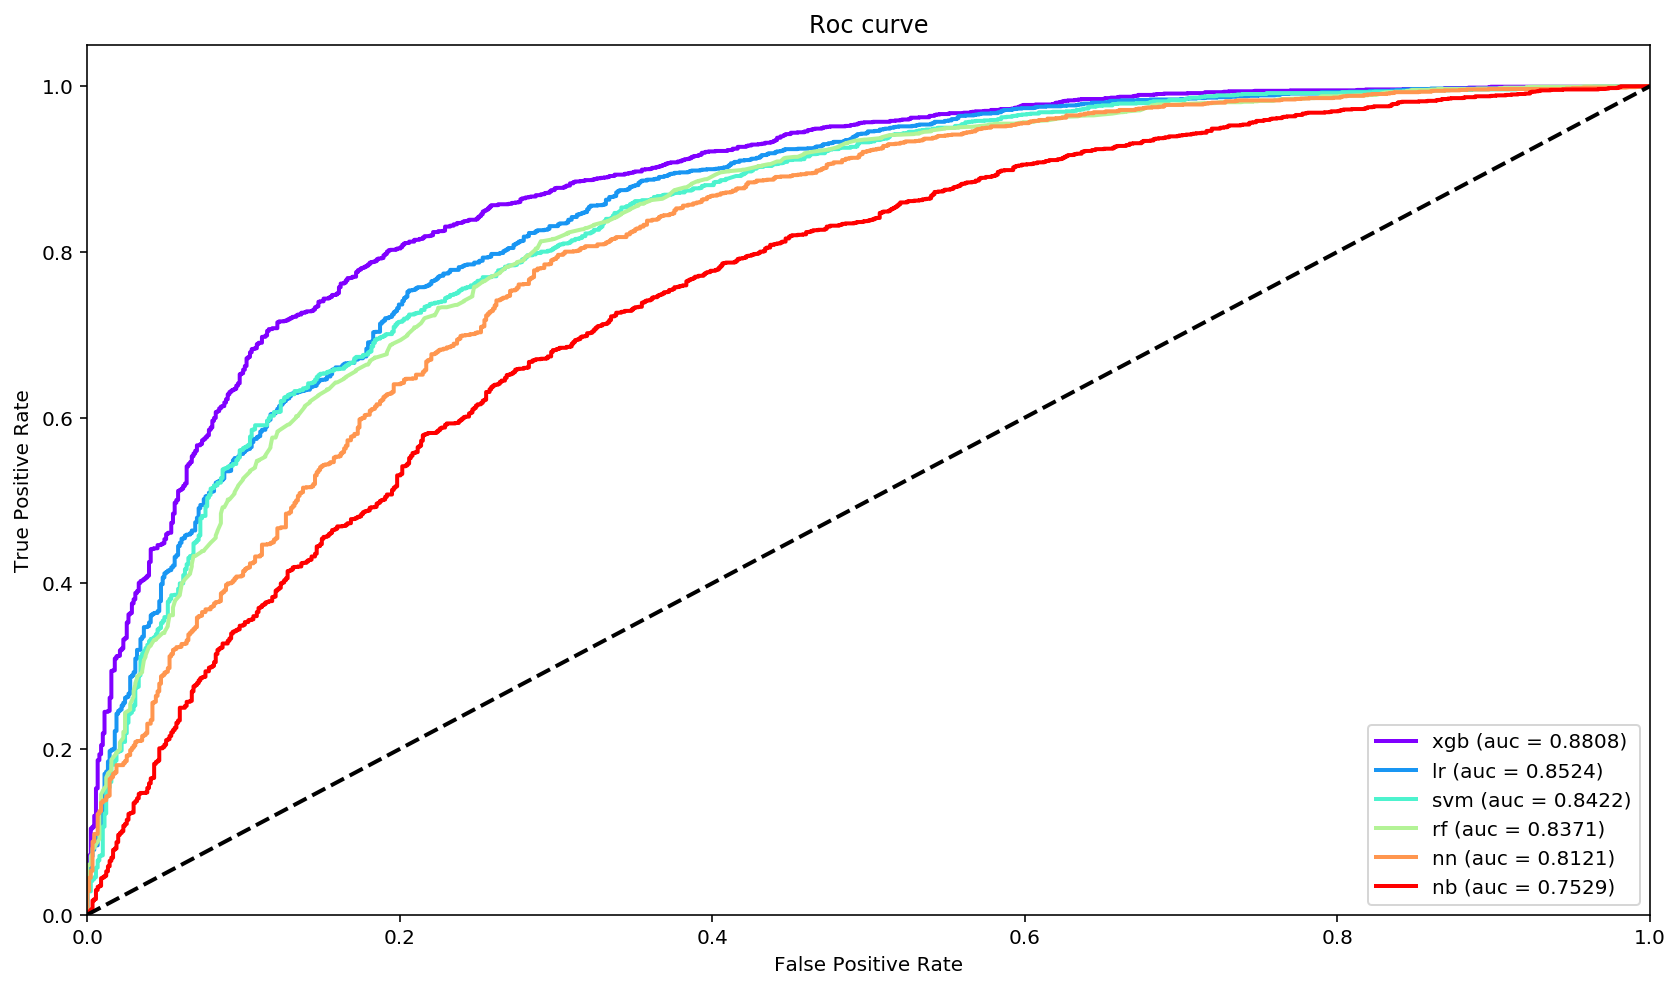

In [39]:
from matplotlib import cm

tmp_models = models_results.index

colors = cm.rainbow(np.linspace(0.0, 1.0, len(tmp_models)))

plt.figure(figsize=(14,8))
lw = 2

for mo, color in zip(tmp_models, colors):
    fpr, tpr, _ = all_models[mo]['roc_curve']
    plt.plot(fpr, tpr, color=color,
         lw=lw, label='{} (auc = {:.4f})'.format(mo, all_models[mo]['result']['auc']))



plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.legend(loc="lower right")

plt.savefig('../output/plots/roc-curves-embeddings.png')

plt.show()

In [40]:
corr_dict = {}
for mo in tmp_models:
    corr_dict[mo] = all_models[mo]['train_preds'] 

In [41]:
kdata_proba = pd.DataFrame(corr_dict)

In [42]:
corr = kdata_proba.corr()
corr

,lr,nb,nn,rf,svm,xgb
lr,1.000000,0.647759,0.862783,0.705705,0.957902,0.653108
nb,0.647759,1.000000,0.715531,0.502018,0.750562,0.420951
nn,0.862783,0.715531,1.000000,0.649046,0.885178,0.585562
rf,0.705705,0.502018,0.649046,1.000000,0.692593,0.989270
svm,0.957902,0.750562,0.885178,0.692593,1.000000,0.627259
xgb,0.653108,0.420951,0.585562,0.989270,0.627259,1.000000


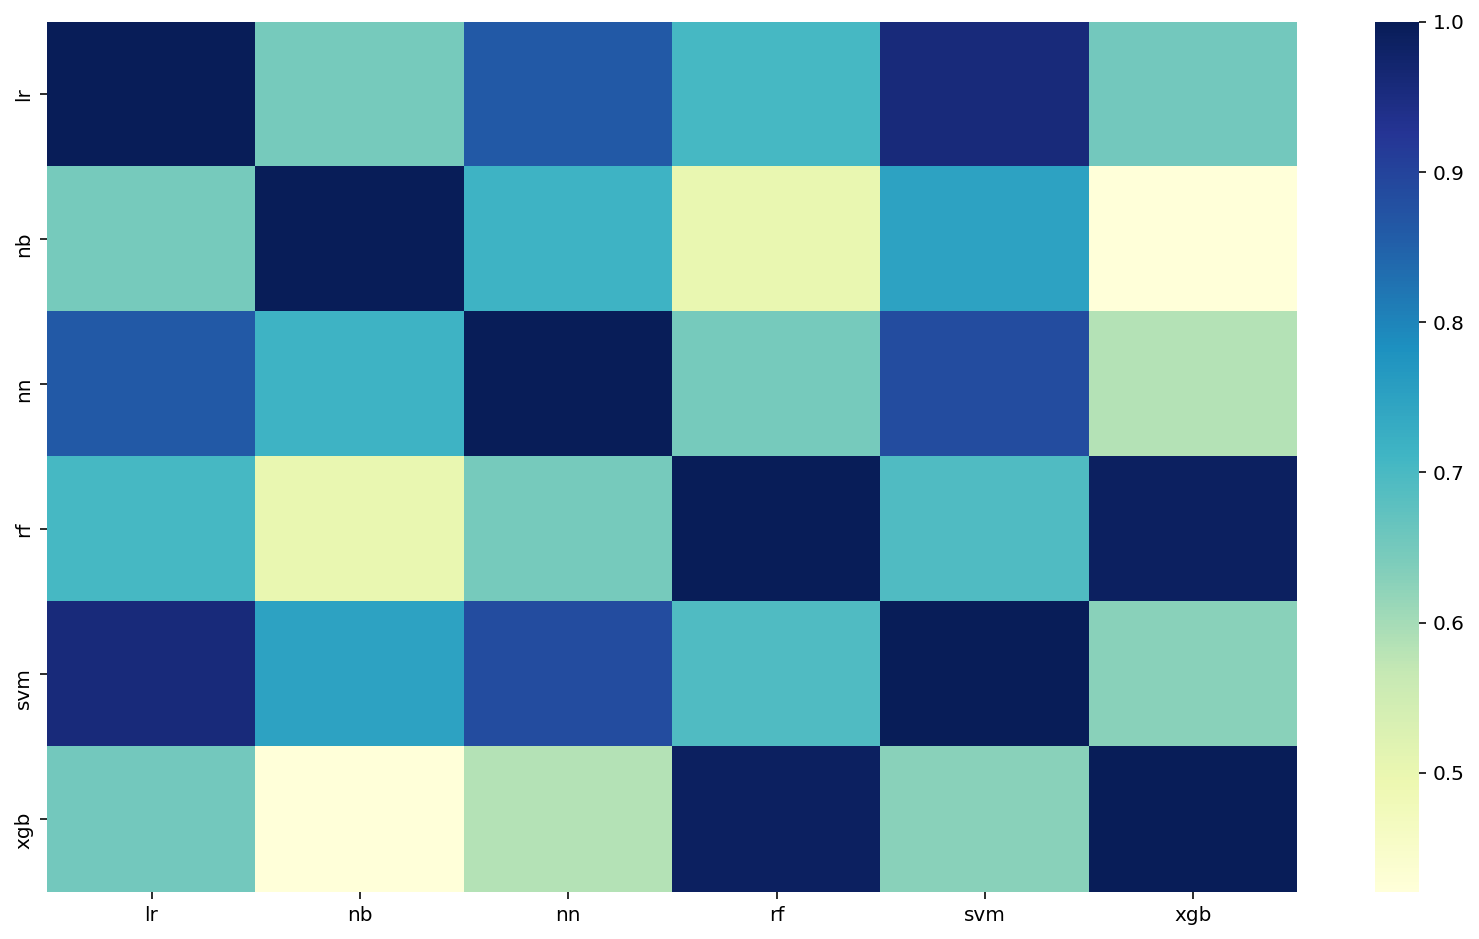

In [43]:
import seaborn as sns

plt.figure(figsize=(14,8))
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

## References

- [Gensim libray](https://radimrehurek.com/gensim/models/word2vec.html)
- [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
- [Text Classification With Word2Vec](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/)
- [Using scikit-learn to find bullies](https://medium.com/towards-data-science/using-scikit-learn-to-find-bullies-c47a1045d92f)